In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import keras

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.facecolor'] = '#FDEFEF'
plt.rcParams['figure.facecolor'] = '#F4DFD0'


In [8]:
df = pd.read_csv("/content/drive/MyDrive/DataScience/Miles_Traveled.csv",index_col='DATE',parse_dates=True)

In [9]:
df.head()

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


Rename the column to 'Miles' and since this is a monthly data, use Monthly frequency 

In [10]:
df.rename(columns={"TRFVOLUSM227NFWA":"Miles"},inplace=True)
df.index.freq = 'MS'

Plot the Data

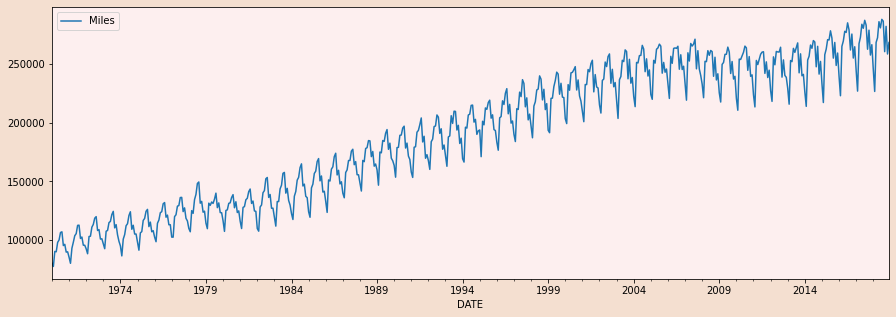

In [11]:
df.plot();

Check for Seasonality

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [13]:
results = seasonal_decompose(df['Miles'])

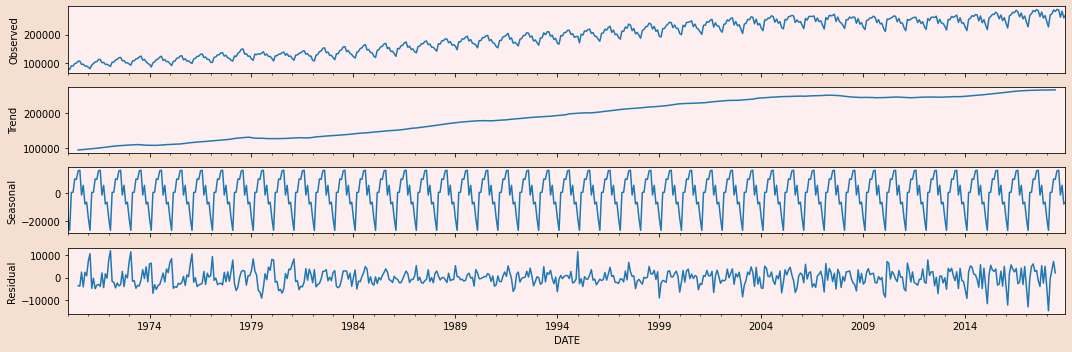

In [14]:
results.plot();

We can see that the data shows seasonality on a yearly basis

Train Test Split

In [15]:
len(df)

588

Keep 1 year of data as test data

In [16]:
train = df[:576]
test = df[576:]

In [17]:
len(test)

12

Perform Scaling

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [20]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

We will use the TimeSeries generator module from Keras to generate an array of samples with input and output elements, using the training data. This will be fed into our LSTM network which will then learn the weights from these samples. For this we will specify the input size as 12 and number of features as one since we only have one input feature.

In [21]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
n_input = 12
n_features = 1

generator = TimeseriesGenerator(data=scaled_train,targets=scaled_train,length=n_input,batch_size=1)

In [23]:
X,y = generator[0]

In [24]:
X.shape # input of size 12

(1, 12, 1)

In [25]:
y.shape # output label

(1, 1)

Here our data will be the 12 elements and the target will be the next element in the training data. The length defines the size of the train data to be taken as input data. Batch size tell how many samples of each input size to be included

Now train the LSTM model on the generated samples above

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [27]:
model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(generator,epochs=30)

Epoch 1/30
564/564 [==============================] - 12s 18ms/step - loss: 0.0131
Epoch 2/30
564/564 [==============================] - 10s 17ms/step - loss: 0.0053
Epoch 3/30
564/564 [==============================] - 10s 17ms/step - loss: 0.0041
Epoch 4/30
564/564 [==============================] - 10s 18ms/step - loss: 0.0027
Epoch 5/30
564/564 [==============================] - 10s 17ms/step - loss: 0.0027
Epoch 6/30
564/564 [==============================] - 10s 17ms/step - loss: 0.0021
Epoch 7/30
564/564 [==============================] - 10s 17ms/step - loss: 0.0016
Epoch 8/30
564/564 [==============================] - 9s 16ms/step - loss: 0.0015
Epoch 9/30
564/564 [==============================] - 9s 17ms/step - loss: 0.0014
Epoch 10/30
564/564 [==============================] - 9s 17ms/step - loss: 0.0014
Epoch 11/30
564/564 [==============================] - 9s 17ms/step - loss: 0.0013
Epoch 12/30
564/564 [==============================] - 10s 17ms/step - loss: 9.3215e-04
E

In [30]:
model.history.history.keys()

dict_keys(['loss'])

Text(0, 0.5, 'Loss')

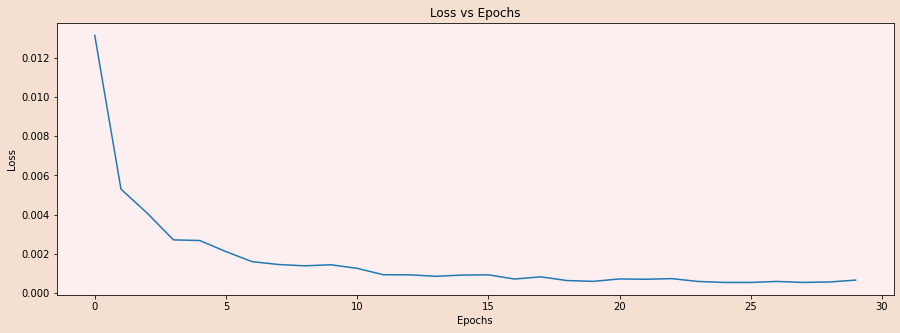

In [31]:
loss = model.history.history['loss']

plt.plot(range(len(loss)),loss);
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Model Evaluation 

We need to evaluate the model trained above on our test data. To do this our test data needs to be in the same shape as our training data. In training we used 12 consecutive data points to predict the next(13th) point. Now we will set the last 12 points as our first evaluation batch to estimate the first test point. Then we will incremently keep on adding more points to the first evaluation batch at the end and removing points from the beginning of the batch until all our test points are covered

In [32]:
first_evaluation_batch = scaled_train[-n_input:]
first_evaluation_batch

array([[0.79630397],
       [0.71226435],
       [0.90477416],
       [0.93121043],
       [0.98386382],
       [0.96757519],
       [1.        ],
       [0.9801859 ],
       [0.8824684 ],
       [0.95995255],
       [0.85883345],
       [0.90086755]])

We will reshape this to be the same shape as that of the generator inputs ie (1,12,1)

In [33]:
first_eval_batch = first_evaluation_batch.reshape(1,n_input,n_features)

In [34]:
first_eval_batch.shape

(1, 12, 1)

In [35]:
model.predict(first_eval_batch)

array([[0.79282546]], dtype=float32)

This gives us a nested array, to get the first value , we can index of the first element

In [36]:
model.predict(first_eval_batch)[0]

array([0.79282546], dtype=float32)

In [45]:
current_batch = first_eval_batch.reshape(1,12,1)
predictions = []
for i in range(24):
    current_pred = model.predict(current_batch)[0]
    predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


In [47]:
len(predictions)

24

Invert the scaling to get true predictions

In [39]:
true_predictions = scaler.inverse_transform(predictions)

In [40]:
true_predictions

array([[243856.85697055],
       [229596.5090071 ],
       [261788.84249121],
       [268172.74338752],
       [279616.24793977],
       [277240.24475116],
       [282818.3323583 ],
       [278325.18011338],
       [262238.99095327],
       [273332.99863815],
       [255976.02210349],
       [262578.80424893]])

In [41]:
test

,Miles
DATE,
2018-01-01,245695.0
2018-02-01,226660.0
2018-03-01,268480.0
2018-04-01,272475.0
2018-05-01,286164.0
2018-06-01,280877.0
2018-07-01,288145.0
2018-08-01,286608.0
2018-09-01,260595.0


In [42]:
test['Predictions'] = true_predictions

In [44]:
test.head(2)

,Miles,Predictions
DATE,,
2018-01-01,245695.0,243856.856971
2018-02-01,226660.0,229596.509007


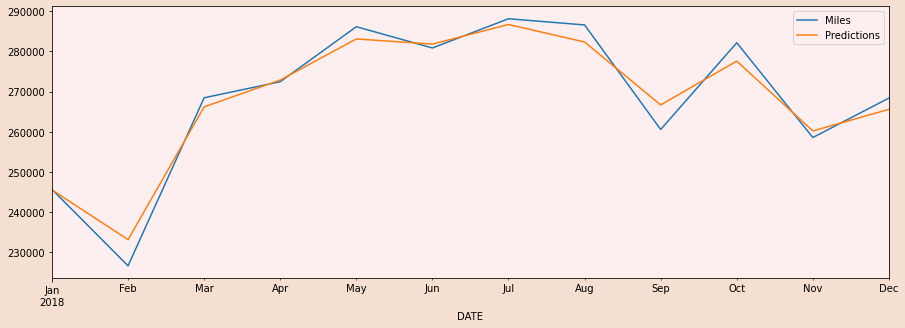

In [90]:
test.plot();

We can see that the predicted values are quite similar in trend and seasonality to the test data

Error

In [91]:
from statsmodels.tools.eval_measures import rmse

In [92]:
error = rmse(test['Miles'],test['Predictions'])
error

3498.465882994526

In [94]:
mean = test['Miles'].mean()

In [95]:
error_percentage = error/mean

In [96]:
error_percentage

0.013018048010507786

So our error is about 1 percent of the mean of the test data which is quite good.